# Introducción

*Preliminares*

La ecuación de Schrödinger en el espacio de configuración es, probablemente, una de las ecuaciones que más información nos pueden dar sobre el mundo microscópico. Como toda ecuación diferencial, sólo se conocen soluciones exactas para los potenciales más sencillos. Cuando queremos considerar sistemas más elaborados hay dos sopas: usar métodos perturbativos y aproximaciones por series de potencias, o usar métodos numéricos. 

Este problema consiste en resolver la ecuación diferencial de segundo orden
$$
\left(-\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x) \right)\psi(x) = E \psi(x)
$$

donde $V(x)$ es el potencial al que está sometida la partícula y $|\psi(x)|^2$ la probabilidad de encontrarla en la posición $x$.

*Método de numerov*

El método de Numerov es un método *marchante* que, a pesar de ser relativamente fácil de implementar, puede arrojar resultados muy cercanos a la realidad.

Para derivarlo, expandimos en serie de Taylor la versión discretizada de $\psi$:
$$\psi(x_{\pm 1})=\psi(x_0) \pm \psi'(x_0) \Delta + \frac{1}{2!}\psi''(x_0)
\Delta^2 \pm \frac{1}{3!}\psi^{(3)}(x_0) \Delta^3 + \frac{1}{4!}\psi^{(4)}(x_0)
\Delta^4 \pm \frac{1}{5!}\psi^{(5)}(x_0) \Delta^5 + \mathcal{O}(\Delta^6)$$

Si sumamos estos compas, tenemos que las potencias impares se nos van:
$$\psi(x_{+ 1})+\psi(x_{- 1}) =2\psi(x_0)  + \psi''(x_0)
\Delta^2 + \frac{1}{12}\psi^{(4)}(x_0)
\Delta^4 + \mathcal{O}(\Delta^6)$$

Si definimos $\delta(g(x))=g(x+\Delta/2) - g(x-\Delta/2)$, tenemos que

$$\delta^2 = \delta(\delta(g))= g(x+\Delta)-g(x) - (g(x) - g(x-\Delta)) $$

Si le aplicamos esta chulada a $\psi$, tenemos que:

$$\delta^2(\psi_n) = \psi_{n+1}  + \psi_{n-1} - 2\psi_n  = \psi''(x_n)
\Delta^2 + \frac{1}{12}\psi^{(4)}(x_n)
\Delta^4 + \mathcal{O}(\Delta^6)$$

Ahora vemos cómo se vería la cuarta derivada como función de la segunda
derivada:

$$\delta^2(\psi''_n) = \psi''_{n+1} + \psi''_{n-1} - 2\psi''_n  = \psi^{(4)}(x_0)
\Delta^2 + \mathcal{O}(\Delta^4)$$ y lo enchufamos en la expresión anterior:

$$\delta^2(\psi_n) = \psi_{n+1} + \psi_{n-1} - 2\psi_n  = \psi''(x_n)
\Delta^2 + \frac{1}{12}\delta^2(\psi''(x_n))
\Delta^2 + \mathcal{O}(\Delta^6)$$

De la ec. de Schrödinger tenemos que $\psi''(x)=f(x)\psi(x)$, con $f(x) = V(x)-E$, que
en lenguaje discreto se ve como $\psi''_n=f_n\psi_n$. Podemos usar esto en la
ecuación anterior para cambiar poner a todas las segundas derivadas en función
de $\psi$:
$$ \psi_{n+1}+\psi_{n-1} - 2\psi_n  = f_{n}\psi_{n}
\Delta^2 + \frac{1}{12}(f_{n+1}\psi_{n+1} + f_{n-1}\psi_{n-1} - 2f_{n}\psi_{n})
\Delta^2 + \mathcal{O}(\Delta^6)$$

Ahora bien, si pasamos los $f_i\psi_i$, del lado izquierdo, se tiene que

$$ \psi_{n+1}\left(1 - \frac{\Delta^2 f_{n+1}}{12}\right) + \psi_{n-1}\left(1 - \frac{\Delta^2 f_{n-1}}{12}\right) - 2\psi_n\left(1 - \frac{\Delta^2 f_{n} }{12}\right)  = f_{n}\psi_{n}
\Delta^2 + \mathcal{O}(\Delta^6)$$ que haciendo $\phi_n = \psi_n(1-\Delta ^2 f_n/12)$ toma la forma

$$ \phi_{n+1} + \phi_{n-1}- 2\phi_n  = f_{n}\psi_{n}
\Delta^2 $$ 

O bien,
$$ \phi_{n+1} =  2\phi_n - \phi_{n-1}  + f_{n}\psi_{n}
\Delta^2 $$ 

De esta fórmula vemos que el método de numerov (como todos los métodos numéricos para segundas derivadas) necesita dos puntos iniciales para empezar a trabajar. Además, recordando la expansión en serie de Taylor, vemos que el error de este método es de orden sexto en $\Delta$.

# Un ejemplo sencillo: pozo infinito

Consideremos la ecuación de Ezkrotinger con un potencial de la forma 
$$
V(x)
\cases{
0, x \in [0,L]\\
\infty, x \notin [0,L]
}
$$

Aunque computacionalmente no es posible usar valores no acotados, el significado físico del potencial infinito es que ahí la función de onda vale 0, lo cual nos da condiciones de frontera en $x=0$ y $x=L$. De ahora en adelante tomaremos $\hbar = L=1$ y $m=1/2$ para simplificar las ecuaciones. En ese caso, sabemos que nuestras soluciones son de la forma 
$$
\psi_n = \sin(kx); \quad k = n\pi \Rightarrow E=n^2\pi^2
$$

In [1]:
using PyPlot

INFO: Loading help data...


In [95]:
#Definimos el numerov de izquierda a derecha
function numerov_L(N, E, f, x_i, x_f)
    g(x) = (f(x) - E)
    Delta = (x_f-x_i)/N
    phi = zeros(Float64, N)
    #definimos los primeros dos elementos
    phi[1] = 0
    phi[2] = 0.001(1 - Delta^2 * g(x_i+Delta)/12)
    #hacemos el paso iterativo
    for i in 3:N
        phi[i] = 2*phi[i - 1] - phi[i - 2] + Delta^2 * g((i - 1) * Delta + x_i) * phi[i - 1] / (1 - Delta^2 * g((i - 1) * Delta+ x_i)/12)
    end
    #regresamos el valor de cada ψ_n  en un arreglo
    return float([phi[i]/((1 - Delta^2 * g(i * Delta + x_i)/12)) for i in 1:N])
end
#Y la que va hacia la izquierda
function numerov_R(N, E, f, x_i, x_f)
    g(x) = (f(x) - E)
    Delta = (x_f-x_i)/N
    phi = zeros(Float64, N)
    #definimos los últimos dos elementos
    phi[end] = 0
    phi[end-1] = 0.001*(1 - Delta^2 * g(x_f-Delta)/12)
    #hacemos el paso iterativo
    for i in reverse(1:N - 2)
        phi[i] = 2*phi[i + 1] - phi[i + 2] + Delta^2 * g((i + 1) * Delta+ x_i) * phi[i + 1] / (1 - Delta^2 * g((i + 1) * Delta+ x_i)/12)
    end
    #regresamos el valor de cada ψ_n  en un arreglo
    return float([phi[i]/((1 - Delta^2 * g(i  * Delta+ x_i)/12)) for i in 1:N])
end



numerov_R (generic function with 1 method)

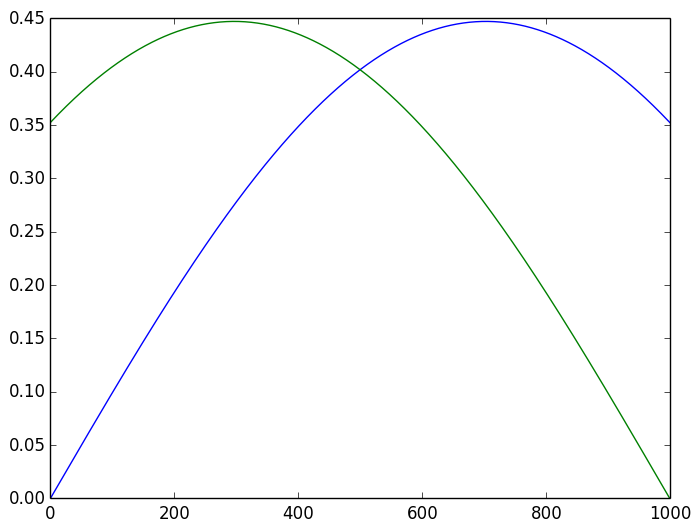

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13f7862c>

In [96]:
#Una pequeña prueba
using PyPlot
funcion(x) = 0
N = 1000
dx =1/N
E = 5
ψ_L = numerov_L(N, E, funcion, 0,1)
ψ_R = numerov_R(N, E, funcion, 0,1)
plot(ψ_L)
plot(ψ_R)


Para el método de disparo no hace falta usar ambas soluciones, pero es reconfortante ver que arrojan resultados similares. 

Para normalizar necesitamos calcular la integral (discreta) de nuestra función. Esta tendrá la forma $|\psi|^2=\sum\psi_i^2\Delta$:

In [87]:
function normaliza(phi, N, x_i, x_f)
    norma=0
    dx = (x_f-x_i)/N
    for i in 1:N
        norma += (phi[i])^2 * (dx)#Se va acumulando el valor de la integral
    end
    return phi ./ (norma)^(1/2) #Se regresa el arreglo de ψ con cada entrada dividida entre la norma.
end

normaliza (generic function with 1 method)

Para el metodo de disparo, necesitamos una función que se regrese el valor de la solución en el extremo. Así que le hacemos algunas modificaciones a `numerov_L`.

In [88]:
function numerov_3xtr3mo(N, E, f, x_i, x_f)
    g(x) = (f(x) - E)
    Delta = (x_f-x_i)/N
    phi = zeros(Float64, N)
    #definimos los primeros dos elementos
    phi[1] = 0
    phi[2] = 0.001(1 - Delta^2 * g(x_i+Delta)/12)
    #hacemos el paso iterativo
    for i in 3:N
        phi[i] = 2*phi[i - 1] - phi[i - 2] + Delta^2 * g((i - 1) * Delta + x_i) * phi[i - 1] / (1 - Delta^2 * g((i - 1) * Delta+ x_i)/12)
    end
    #hasta ahora,  hizo lo mismo, pero aquí sólo regresa el último valor del arreglo
    i=N
    return phi[i]/((1 - Delta^2 * g((i - 1) * Delta)/12))
end

numerov_3xtr3mo (generic function with 1 method)

Definimos una función que implementa el método de bisección. El método de disparo consiste en encontrar los ceros de `numerov_3xtr3mo`, pues representan las energías $E_i$ para las cuales $\psi(x)$ satisface las condiciones a la frontera.

In [5]:
function bisec(a,b,paso,f)
    if paso == 100
        (a + b)/2
    elseif sign(f(a)) != sign(f((a+b)/2))
        bisec(a,(a + b)/2,paso + 1,f)
    elseif sign(f(b)) != sign(f((a + b)/2))
        bisec((a + b)/2,b,paso + 1,f)
    else
        println("La función no cambia de signo en $a, $b.")
        println("Intenta con otro intervalo.")
    end
end

bisec (generic function with 1 method)

In [97]:
#Juntamos todo en una rutina eficiente y guapa
function numerov_shooting(N, a, b, f, x_i, x_f)
    E_0 = bisec(a, b, 1, (u->numerov_3xtr3mo(N, u, f, x_i, x_f)))
    normaliza((numerov_R(N, E_0, f, x_i, x_f)), N, x_i, x_f), E_0
end


numerov_shooting (generic function with 1 method)

In [98]:
N=100
funcion(x)=0
ψ , E = numerov_shooting(N, 0, 15, funcion, 0,1)

([-1.14074e-15,0.0450961,0.0901468,0.135107,0.179931,0.224573,0.26899,0.313136,0.356966,0.400437  …  0.400437,0.356966,0.313136,0.26899,0.224573,0.179931,0.135107,0.0901468,0.0450961,0.0],10.069997305771487)

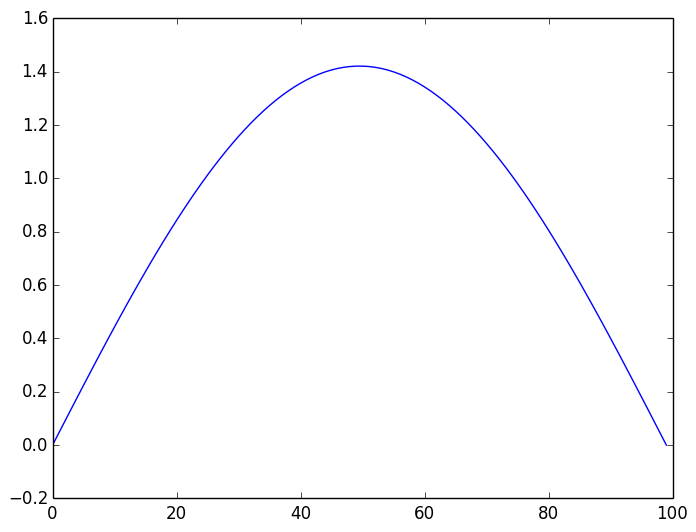

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1402870c>

In [99]:
#Graficamos la solución
plot(ψ)

Esa función de onda se parece a la del estado base, así que le echamos un ojo a la energía que debería tener:

In [10]:
pi^2

9.869604401089358

Y vemos que coincide bastante bien con el valor de $10.07$ que obtuvimos con el método de Numerov. Vamos a buscar más arriba a ver si encontramos la dependencia cuadrática:

In [11]:
N=100
funcion(x)=0
ψ , E = numerov_shooting(N, 15, 50, funcion, 0,1)

([0.0,0.0901468,0.179931,0.26899,0.356966,0.443505,0.528258,0.610884,0.69105,0.768433  …  -0.768433,-0.69105,-0.610884,-0.528258,-0.443505,-0.356966,-0.26899,-0.179931,-0.0901468,-6.07913e-15],40.27998666979116)

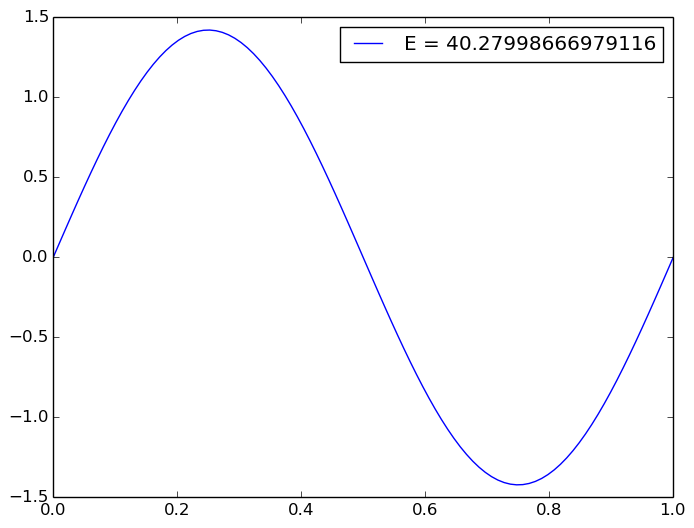

PyObject <matplotlib.legend.Legend object at 0x7f22d9ba78d0>

In [12]:
#La energía se parece a  $2^2 π^2$, vamos a ver si la función se comporta como debe:
x = linspace(0,1,N)
plot(x,ψ, label = "E = $E")
legend(loc=1)

Y vemos que lo hace :). Más aún, hay que reconocer que obtuvimos valores de la energía (la cantidad física más relevante de este sistema) con un error de menos del $10\%$, a pesar de usar tan sólo una malla de $100$ puntos, cosa bastante sorprendente.  Encontrar los eigenvalores subsecuentes simplemente requiere seguir probando distintos intervalos.

Ahora vale la pena explorar potenciales más complicados, pues el pozo infinito es el más sencillo (y el menos físico, para ser francos). Por ejemplo, podemos pensar en un pozo infinito con una barrera finita adentro y analizar cómo cambian los estados de este sistema con respecto a los del pozo sencillito. Así,
$$
V(x)=
\begin{cases}
0, &x\notin [0.2,0.4]\\
10, &x\in [0.2,0.4]
\end{cases}
$$

In [13]:
#Armamos la malla
N=100
#Definimos al potencial
function V(x)
    if x<=0.4 && x>=0.2
        return 10
    else
        return 0
    end
end
#Y hacemos la machaca
ψ , E = numerov_shooting(N, 0, 15, V, 0,1)

([0.0,0.0386203,0.0771927,0.115669,0.154002,0.192144,0.230048,0.267666,0.304952,0.34186  …  0.455315,0.406158,0.356498,0.306395,0.255912,0.205112,0.154057,0.102811,0.0514374,-1.49689e-15],12.408289890038702)

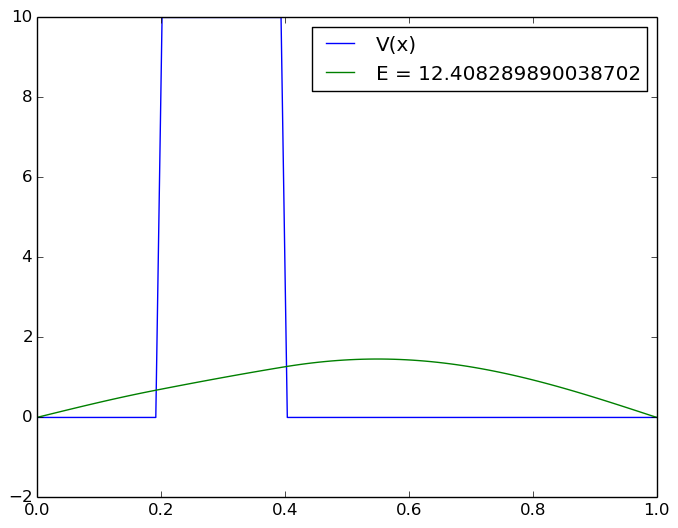

PyObject <matplotlib.legend.Legend object at 0x7f22d9addad0>

In [14]:
#Vamos a graficarla junto con el potencial para analizar el comportamiento
x = linspace(0,1,N)
V_x = map(V, x)
plot (x, V_x, label = "V(x)")
plot (x, ψ, label = "E = $E")
legend(loc=1)

Y vemos que el método funciona bien y nota el cambio en la energía del estado base. Podemos analizar un potencial con un vado en lugar de una barrera:
$$
V(x)=
\begin{cases}
0, &x\notin [0.2,0.4]\\
-10, &x\in [0.2,0.4]
\end{cases}
$$

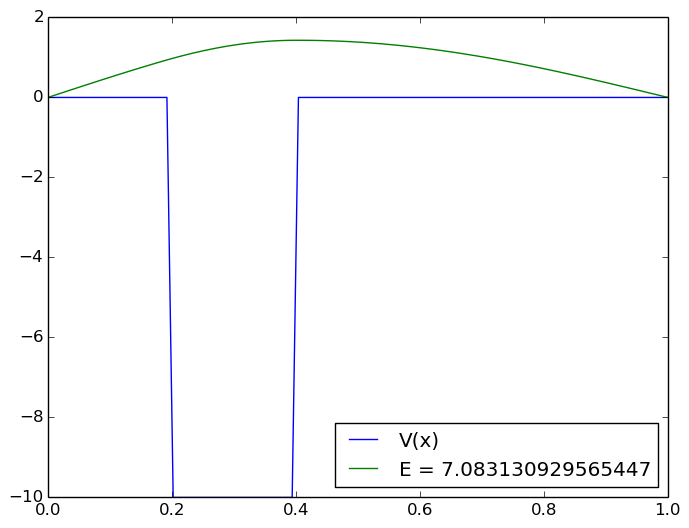

PyObject <matplotlib.legend.Legend object at 0x7f22d9a23d90>

In [15]:
#Armamos la malla
N=100
#Definimos al potencial
function V2(x)
    if x<=0.4 && x>=0.2
        return -10
    else
        return 0
    end
end
#Y hacemos la machaca
ψ , E = numerov_shooting(N, 0, 15, V2, 0,1)
#Vamos a graficarla junto con el potencial para analizar el comportamiento
x = linspace(0,1,N)
V_x = map(V2, x)
plot (x, V_x, label = "V(x)")
plot (x, ψ, label = "E = $E")
legend(loc="lower right")

Esta vez la energía del estado base es menor y el pico de mayor probabilidad se cargó hacia el vado. 

Ahora sigue intentar atacar potenciales que no tengan barreras perfectas. Y el primer pasito es el oscilador armónico:
$$
V(x) = \frac{1}{2} m \omega^2 x^2
$$
que con $\omega = 2$ y $m = 1/2$ toma la forma

$$
V_o(x) = x^2
$$

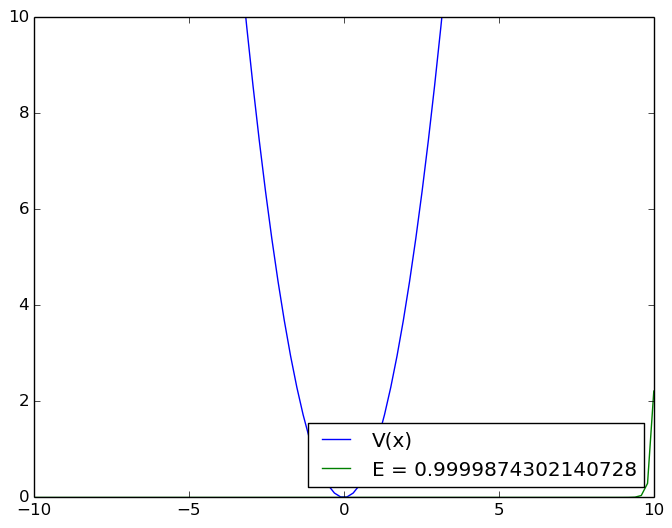

(0,10)

In [16]:
#Hacemos lo mismo con este potencial nuevo
N=100
V_o(x) = (x)^2
x_i = -10
x_f = 10
ψ , E = numerov_shooting(N, 0, 5, V_o, x_i,x_f)
#Vamos a graficarla junto con el potencial para analizar el comportamiento
x = linspace(x_i,x_f,N)
V_x = map(V_o, x)
plot (x, V_x, label = "V(x)")
plot (x, ψ, label = "E = $E")
legend(loc="lower right")
ylim(0,10)

Y vemos que la solución que se construye arrancando desde la izquierda, truena horrible hacia la derecha. Es evidente que la de la derecha hará algo análogo. Este tipo de problemas deben ser atacados con el *método de igualación*, que será expuesto en la próxima sección.


# Método de igualación

No siempre conocemos $\psi$ y $d\psi/dx$. Por lo que sólo podemos usar
la continuidad de $\psi$

Para el potencial J-L, la función de onda desaparecerá para $x$ grande
y pequeña. Consideramos $\psi_0 = \psi_L = 0$ y a $d\psi/dx \vert_0 =
d/\psi/dx \vert_L = \mathit{pequeño}$.

Hacemos dos integraciones: una de derecha a izquierda y otra de
izquierda a derecha. El objetivo es __emparejar__ estas funciones para
obtener una solución usando que $\psi$ y $d\psi/dx$ son continuas.

Primero empatamos las funciones utilizando constantes $a$ y $b$ tal
que, $a\psi$ y $b\psi$ coincidan en un punto encima del mínimo del
potencial. Para empatar las derivadas, usamos la adivinanza de la
energía.

Para potenciales no simétricos hay que hacer una rutina que empata a
$\psi_l$ y a $\psi_r$ cerca del mínimo del potencia.

In [17]:
N = 100
x = zeros(N);

In [18]:
dx=1e-2

0.01

# Potencial de Lennard-Jones

El potencial de Lennard-Jones está definido como
$$
u(x) \equiv 4\epsilon\left((\sigma/x)^{12}-(\sigma/x)^6\right)
$$

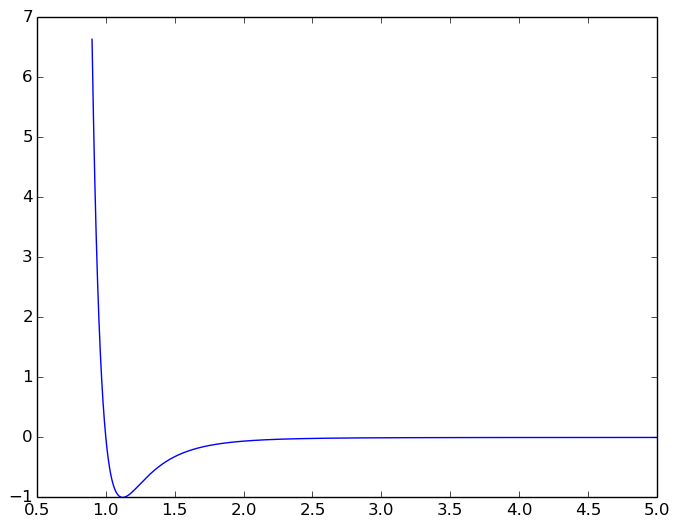

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f22d978e850>

In [58]:
u = Float64[]
for x in .9:dx:5
    push!(u,4(1/x^12-1/x^6))
end

x = [.9:dx:5]
plot(x,u)

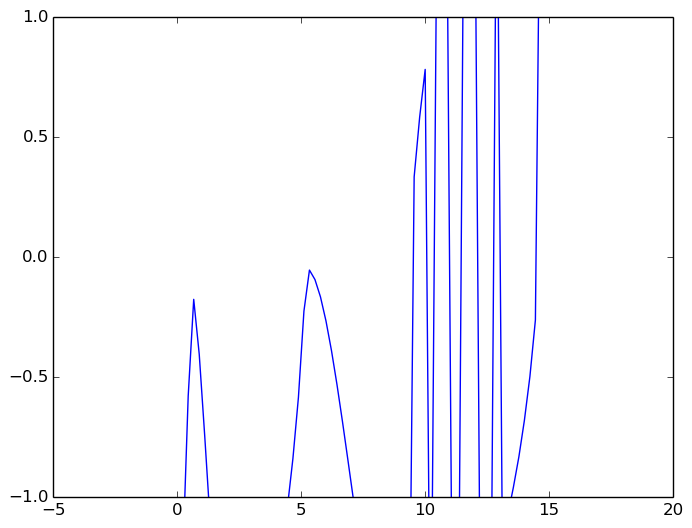

(-1,1)

In [85]:
h = linspace(-2,20)
j = [todo2(N,x,lj,.9,5) for x in h]
plot(h,j)
ylim(-1,1)

In [78]:
bisec(-2.,-1.,1,x->todo2(N,x,lj,.2,.3))

La función no cambia de signo en -2.0, -1.0.
Intenta con otro intervalo.


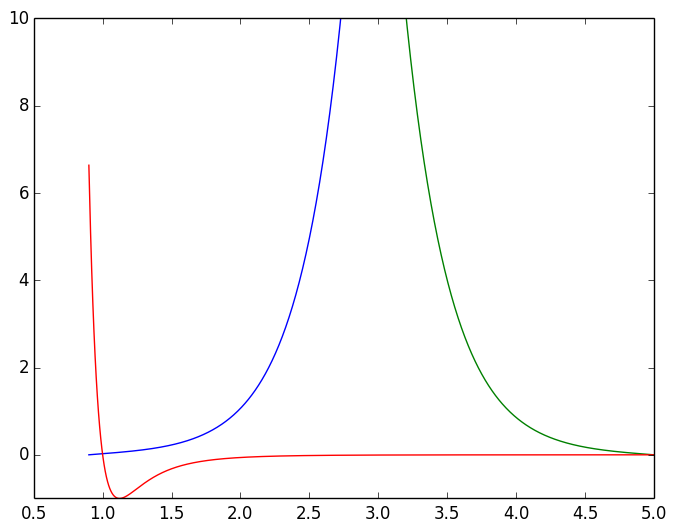

(-1,10)

In [100]:
#Probamos
lj(x) = 4(1/x^12-1/x^6)
N = 1000
dx =1/N
x = linspace(0.9,5,N)
E = -1.9296619399299941
ψ_L = numerov_L(N, E, lj, 0.9, 10)
ψ_R = numerov_R(N, E, lj, 0.9, 10)
plot(x, ψ_L)
plot(x, ψ_R)
u = [lj(u) for u in x]
plot(x, u)
ylim(-1,10)

In [12]:
function derdes(a,b)
    valor = 0
    for i in 1:length(a)
        if minimum(abs(b-a)) == abs((b-a)[i])
            valor = i
        end
    end
    (b[valor]-b[valor-1])/dx-(a[valor]-a[valor-1])/dx
end

function funcs(E,V)
    Ψl = zeros(float(V))
    Ψl[1] = 0
    Ψl[2] = dx
    Ψr = zeros(float(V))
    Ψr[end] = 0
    Ψr[end-1] = dx
    for i in 2:length(V) - 1
        Ψl[i+1] = 2Ψl[i] - Ψl[i-1] - 2*(dx)^2*(E-V[i])*Ψl[i]
    end
    for i in reverse(2:length(V) - 1)
        Ψr[i-1] = 2Ψr[i] - Ψr[i+1] - 2*(dx)^2*(E-V[i])*Ψr[i]
    end
    Ψl,Ψr
end

function todo(e,v)
    a,b=funcs(e,v)
    derdes(a,b)
end

todo (generic function with 1 method)

In [13]:
function todo2(N, E, V, x_i, x_f)
    a = numerov_L(N, E, V, x_i, x_f)
    b = numerov_R(N, E, V, x_i, x_f)
    derdes(a,b)
end

todo2 (generic function with 1 method)

In [87]:
todo2(1000,0.,lj,.9,5)

-1.7888375698402736

In [24]:
lj(x) = 4(1/x^12-1/x^6)
N = 1000
dx =1/N
x = linspace(0.9,10,N)
E = bisec(-15,5,1,x->todo2(N,x,lj,0.9,10))

La función no cambia de signo en -15, 5.
Intenta con otro intervalo.


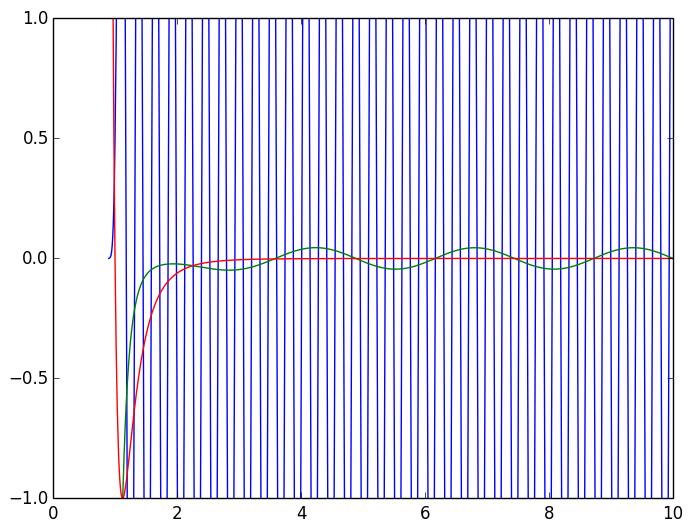

(-1,1)

In [40]:

E = 500
ψ_L = numerov_L(N, E, lj, 0.5, 10)
ψ_R = numerov_R(N, E, lj, 0.5, 10)
x = linspace(0.9,10,N)
plot(x, ψ_L)
plot(x, ψ_R)
u = [lj(u) for u in x]
plot(x, u)
ylim(-1,1)

## Estado base de Lennard-Jones

In [60]:
a,b=funcs(.259,u)

([0.0,0.001,0.00200001,0.00300005,0.00400012,0.00500024,0.00600042,0.00700066,0.00800098,0.00900139  …  -0.00528081,-0.00600658,-0.00673235,-0.00745811,-0.00818387,-0.00890963,-0.00963538,-0.0103611,-0.0110869,-0.0118126],[-0.0118126,-0.010437,-0.00906162,-0.00768631,-0.00631109,-0.00493595,-0.00356086,-0.00218581,-0.000810784,0.000564233  …  0.00899994,0.00799996,0.00699997,0.00599998,0.00499999,0.00399999,0.003,0.002,0.001,0.0])

In [61]:
length(u)

4101

In [62]:
length(a)

4101

In [63]:
length(x)

4101

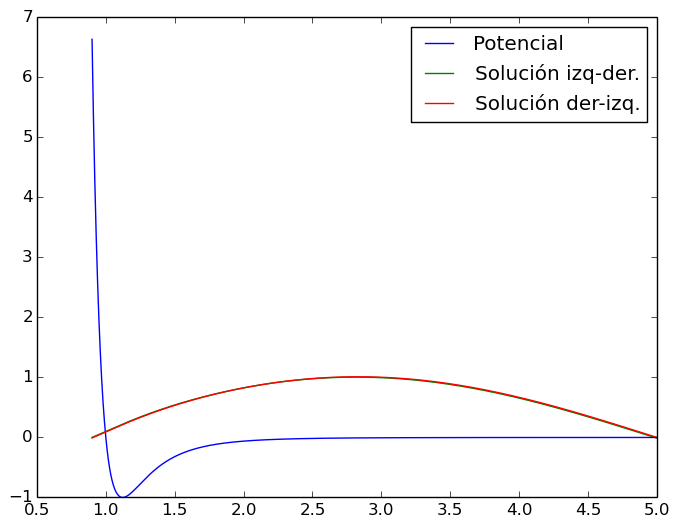

PyObject <matplotlib.legend.Legend object at 0x7f22d9613290>

In [64]:
x = [.9:dx:5]
plot(x,u,label="Potencial")
plot(x,a,label="Solución izq-der.")
plot(x,.73*b,label="Solución der-izq.")
legend()

# Oscilador armónico

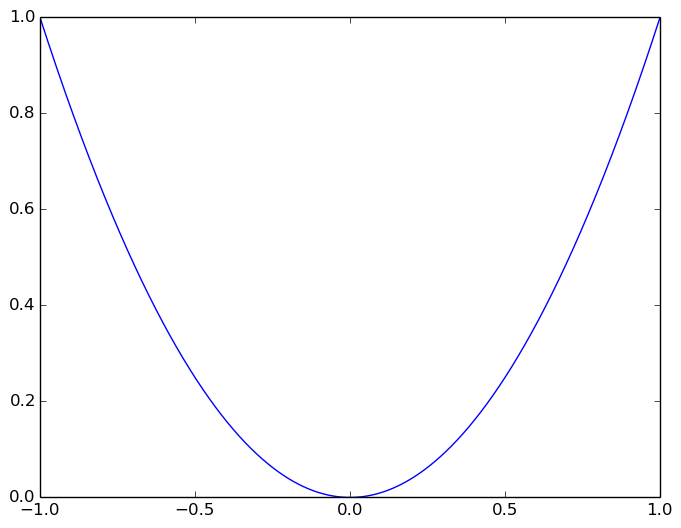

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f22d946de50>

In [65]:
u = Float64[]

for x in -1:dx:1
    push!(u,x^2)
end

x = [-1:dx:1]
plot(x,u)

Encontramos __visualmente__ los puntos en donde la diferencia de las derivadas es cero. Después usamos `bisec` para hacerlo __numéricamente__.

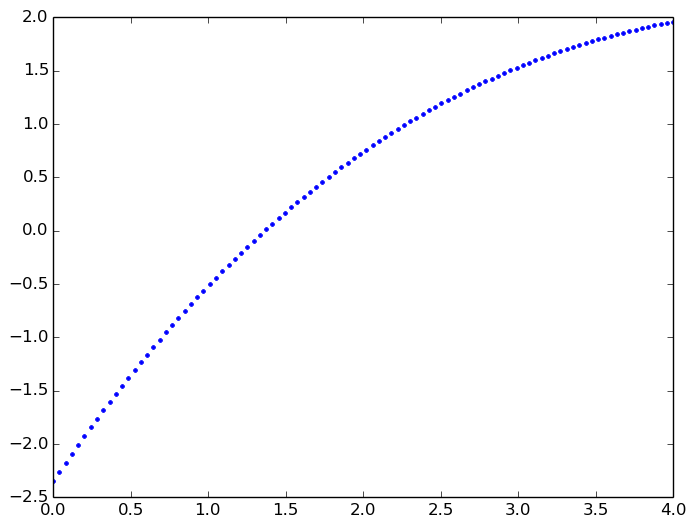

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f22d9389410>

In [66]:
x = linspace(0,4)
y = [todo(r,u) for r in x]
plot(x,y,".")

In [67]:
bisec(0,4,1,x->todo(x,u))

1.3620703338396498

## Estado base oscilador armónico

Utilizando el resultado de `bisec` encontramos las soluciones y las graficamos junto al potencial.

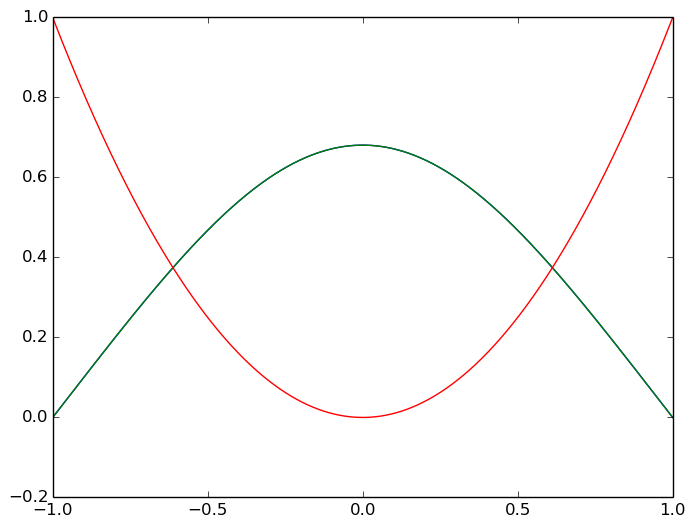

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f22d9370210>

In [68]:
a,b=funcs(bisec(0,4,1,x->todo(x,u)),u)
x = [-1:dx:1]
plot(x,a)
plot(x,b)
plot(x,u)

## Segundo estado excitado

In [69]:
bisec(5,15,1,x->todo(x,u))

11.414527516210974

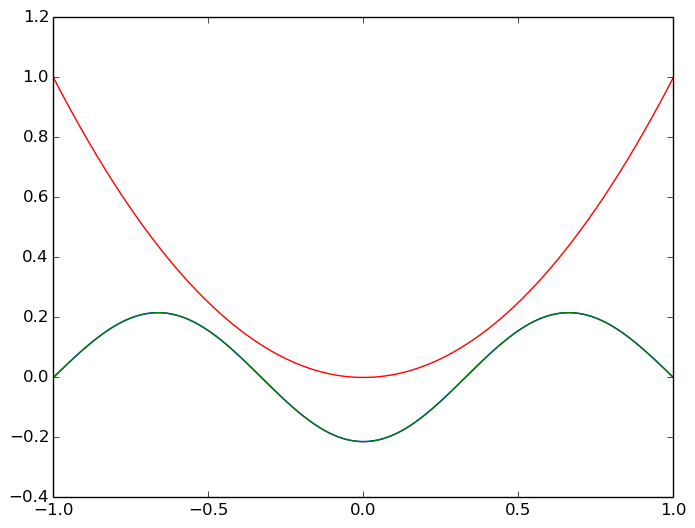

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f22d91cb1d0>

In [71]:
a,b=funcs(bisec(5,15,1,x->todo(x,u)),u)
x = [-1:dx:1]
plot(x,a)
plot(x,b)
plot(x,u)

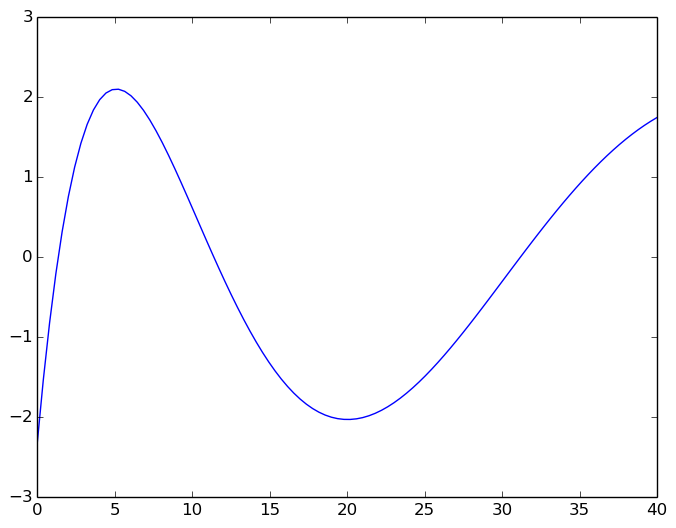

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f22d92fe690>

In [70]:
r=linspace(0,40)
t=[todo(k,u) for k in r]
plot(r,t)

## Método de igualación + Numerov

Vamos a tratar de aplicar la idea del método de igualación a las soluciones obtenidas con numerov de cada lado. Encontraremos los ceros de `derdes`, pues representan las energías $E_i$ para las cuales las soluciones empatan. Retomamos el potencial del oscilador armónico:

In [ ]:
N=1000
V_o(x) = (x)^2
x_i = -5
x_f = 5
E = bisec(0,2,1,x->todo2(N,x,V_o,x_i, x_f))

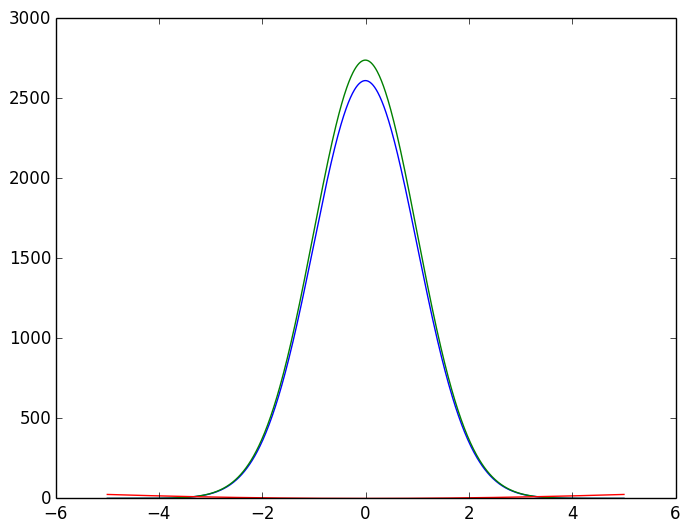

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x140766cc>

In [102]:
E = 1
ψ_L = numerov_L(N, E, V_o, x_i, x_f)
ψ_R = numerov_R(N, E, V_o, x_i, x_f)
x = linspace(x_i, x_f,N)
plot(x, ψ_L)
plot(x, ψ_R)
u = [V_o(u) for u in x]
plot(x, u)
#ylim(1,5)